In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [65]:
# Importing dependencies for the model
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, dataset
from torchvision.utils import make_grid

In [66]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RamdomHorizontalFlip(),
    transforms.RandomRotation(10)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizing for each channel
])

# Loading data from torch 
train_set = datasets.CIFAR10(root='./data', download=True, train=True, transform=transform)
train_dataloader = DataLoader(train_set, batch_size=128, shuffle=True)

test_set = datasets.CIFAR10(root='./data', download=True, train=False, transform=transform)
test_dataloader = DataLoader(test_set, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [80]:
from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(train_set, test_size=0.2, random_state=42)

In [81]:
import numpy as np
import matplotlib.pyplot as plt

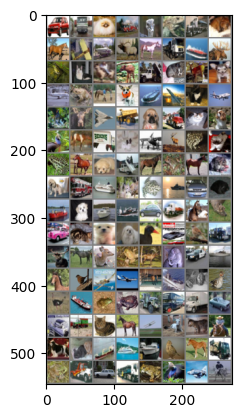

Labels: 1 9 5 9 2 6 9 5 7 0


In [82]:
data_iter = iter(train_dataloader)
images, labels = next(data_iter)

def imshow(img):
    
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
imshow(make_grid(images))
print('Labels:', ' '.join(f'{labels[j].item()}'for j in range(10)))

In [83]:
import torch.nn.functional as F

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(96)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(384)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(384)
        
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=256*4*4, out_features=4096)
        self.drp1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(in_features=4096, out_features=4096)
        self.drp2 = nn.Dropout(p=0.5)
        
        self.fc3 = nn.Linear(in_features=4096, out_features=10)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        
        x = F.relu(self.conv5(x))
        x = self.pool3(x)
        
        # Flatten the tensor before passing it to the fully connected layers
        x = x.view(x.size(0), -1)  # Flatten the output
        x = F.relu(self.fc1(x))
        x = self.drp1(x)
        x = F.relu(self.fc2(x))
        x = self.drp2(x)
        x = self.fc3(x)
        
        return x

In [85]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [86]:
model = AlexNet().to(device)

In [87]:
# initializing optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [88]:
num_epochs = 20# Initialize your model, criterion, and optimizer

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        # Print shapes for debugging
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    if (epoch + 1) % 2 == 0:
        avg_loss = running_loss / len(train_dataloader)
        print(f'Epoch: [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch: [2/20], Loss: 1.3481
Epoch: [4/20], Loss: 0.9278
Epoch: [6/20], Loss: 0.7329
Epoch: [8/20], Loss: 0.5880
Epoch: [10/20], Loss: 0.4746
Epoch: [12/20], Loss: 0.3730
Epoch: [14/20], Loss: 0.2830
Epoch: [16/20], Loss: 0.2015
Epoch: [18/20], Loss: 0.1418
Epoch: [20/20], Loss: 0.0896


In [89]:
val_dataloader = DataLoader(val_set, batch_size=128, shuffle=False)

In [93]:
# Validation phase of training
model.eval()

correct = 0
total = 0 
val_loss = 0
with torch.no_grad():
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        
        # Compute predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # Update correct and total
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
# Calculate average validation loss and accuracy
val_loss = val_loss / len(val_dataloader)
val_accuracy = (correct / total) * 100
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.2f}%')


Validation Loss: 0.1311
Validation Accuracy: 95.35%


In [101]:
# Testing phase
model.eval()
correct = 0
total = 0
test_loss = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)sss
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
test_loss /= len(test_dataloader)
test_accuracy = 100 * correct / total

print(f'Accuracy: {test_accuracy:.4f}%')
print(f'Test loss: {test_loss:.4f}')

Accuracy: 78.3000%
Test loss: 0.0000
